In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
pnl = 0
DATA_DIR       = './data'
SYMBOLS_CSV    = 'symbols.csv'
WINDOW_SIZE    = 183
WIDE_SIZE      = 403
VOLUME_THRESHOLD = 100_000
NOTIONAL       = 100.0

In [3]:
def prepare_data():
    symbols = pd.read_csv(SYMBOLS_CSV)['symbol'].iloc[:-4].tolist()
    data_dict = {}
    for sym in symbols:
        df = pd.read_csv(os.path.join(DATA_DIR, f'{sym}.csv'))
        df['open_time'] = pd.to_datetime(df['open_time'])
        df[['open','high','low','close','volume']] = df[['open','high','low','close','volume']].apply(pd.to_numeric, errors='coerce')
        df.sort_values('open_time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        df['time_index'] = (df['open_time'] - df['open_time'].iloc[0]).dt.total_seconds()
        data_dict[sym] = df
    return data_dict

In [4]:
def create_model(df):
    X = sm.add_constant(df['time_index'])
    y = df['close']
    return sm.OLS(y, X).fit()

In [5]:
def get_predictions(df, model, alpha=0.01):
    X_new = sm.add_constant(df['time_index'])
    return model.get_prediction(X_new).summary_frame(alpha=alpha)

In [6]:
def get_slope(df, pred_summary):
    x0, xN = df['time_index'].iloc[0], df['time_index'].iloc[-1]
    y0, yN = pred_summary['mean'].iloc[0], pred_summary['mean'].iloc[-1]
    pct_change = (yN - y0) / y0 * 100
    minutes = (xN - x0) / 60
    return pct_change / minutes if minutes > 0 else 0

In [7]:
def get_lower_series(lower_series, horizon=WIDE_SIZE):
    n = len(lower_series)
    slope = (lower_series.iloc[-1] - lower_series.iloc[0]) / (n - 1)
    intercept = lower_series.iloc[0]
    x = np.arange(horizon)
    return pd.Series(intercept + slope * x)

In [8]:
def get_next_low(lower_series, x=183):
    n = len(lower_series)
    slope = (lower_series.iloc[-1] - lower_series.iloc[0]) / (n - 1)
    intercept = lower_series.iloc[0]
    return intercept + slope * x

In [9]:
def draw(window, lower_preds, ticker, sell_time, sell_price,buy_time,buy_price):
    df = window.copy()
    last_price = df['close'].iloc[-1]
    last_time = df['open_time'].iloc[-1]
    last_lower = lower_preds.iloc[-1]

    plt.figure(figsize=(14, 6))
    plt.plot(df['open_time'], df['close'], label='Real Price',color='black',linewidth=1)
    plt.plot(df['open_time'], lower_preds.iloc[:len(df)], '--', label='Lower CI Projection')
    plt.axvline(x=df['open_time'].iloc[183], color='red', linestyle='--', label='Knowledge Base')
    plt.scatter([sell_time], [sell_price], color='red', label='Signal Price')
    plt.scatter([buy_time], [buy_price], color='green', label='Signal Price')
    
    plt.text(last_time, last_price, f' Last Price: {last_price:.6f}', color='orange', fontsize=10)
    plt.text(last_time, last_lower, f' ↓ {last_lower:.6f}', color='red', fontsize=10)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'Sell Signal - {ticker}')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
stop_slope = []
tp_slope = []

sell_bar = None
sell_time = None
sell_price = None
df = None

We are at index: 0
Opening position
sold at 3424.19, took profit at 3407.069050   pnl: 0.5
Slope of lower ci: 0.003742273263485838


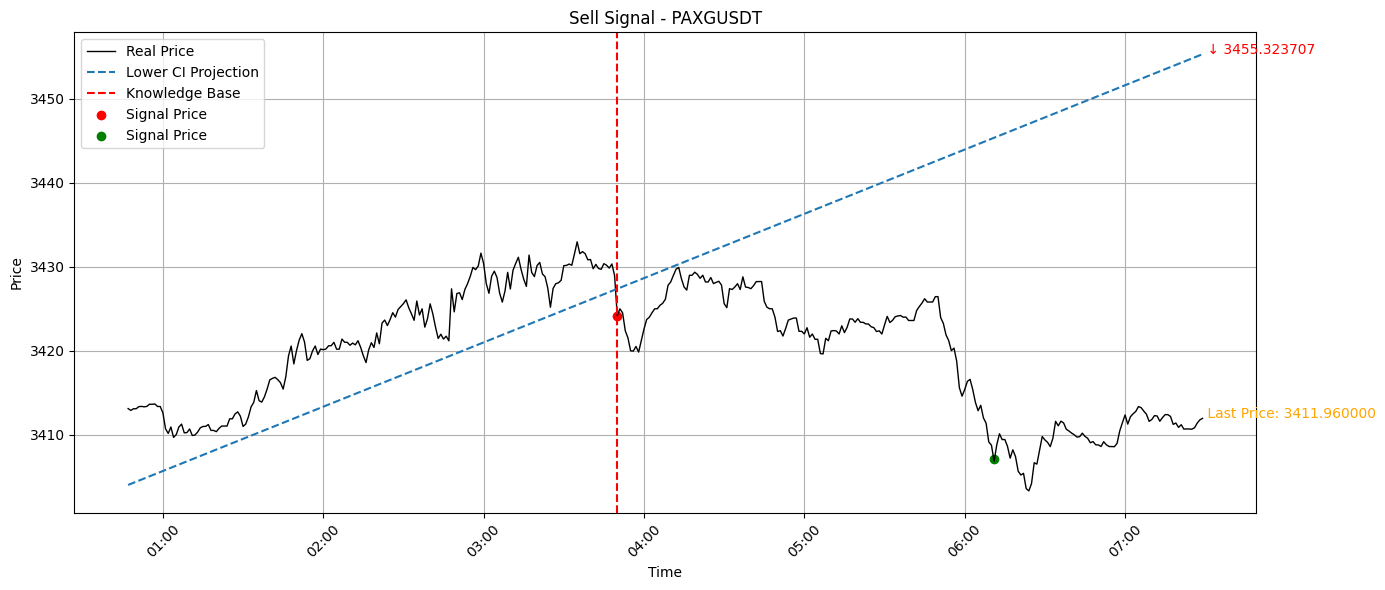

Opening position
sold at 0.3522, stop loss @0.353961   pnl: 0.0
Slope of lower ci: 0.012764114050432231


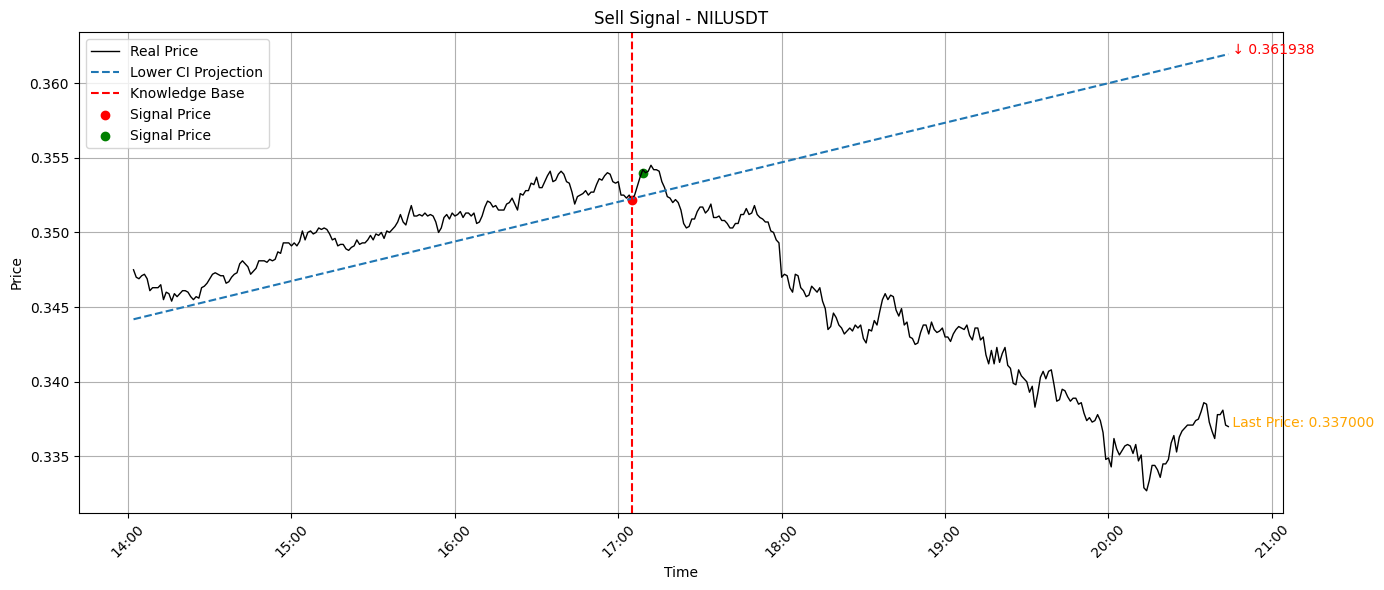

Opening position
sold at 0.3524, took profit at 0.350638   pnl: 0.5
Slope of lower ci: 0.012586245173943723


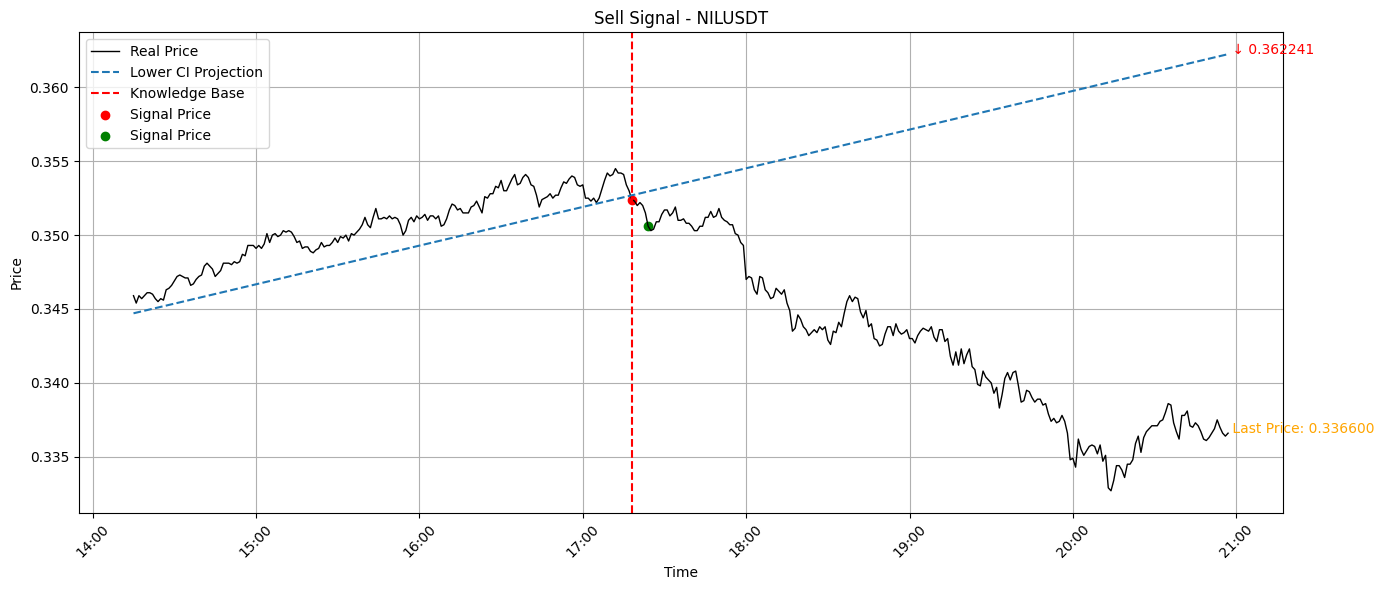

Opening position
sold at 0.003399, stop loss @0.003416   pnl: 0.0
Slope of lower ci: 0.01612256416008353


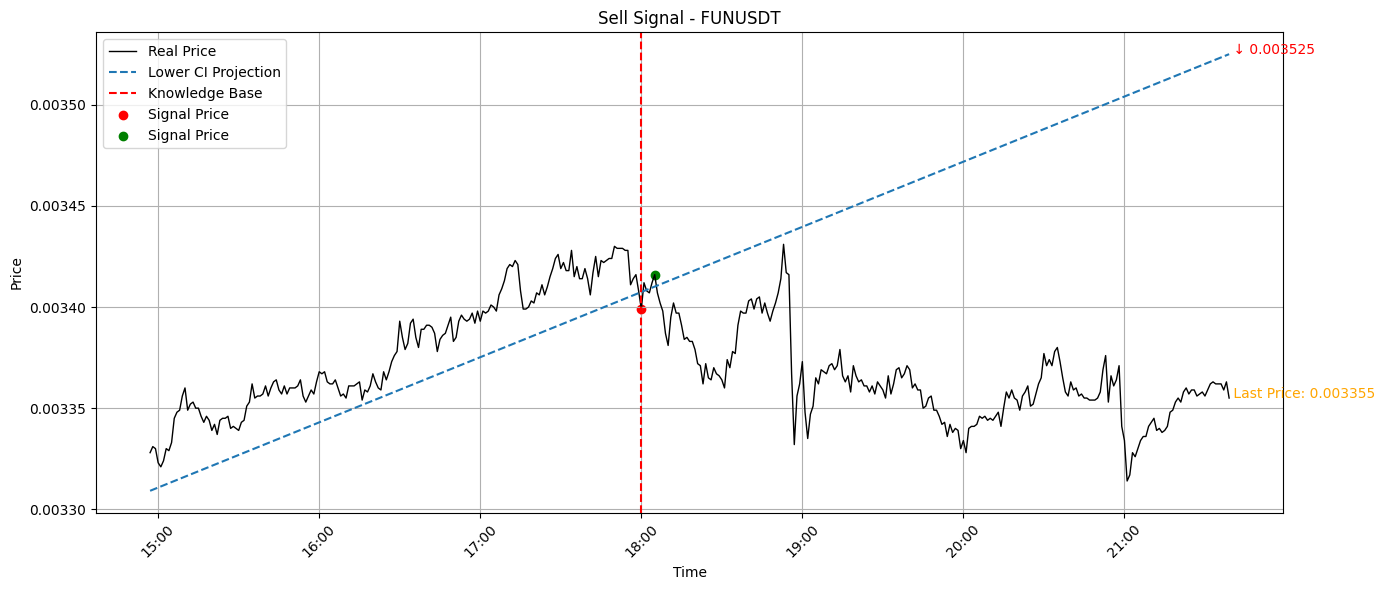

Opening position
sold at 0.003402, took profit at 0.003385   pnl: 0.5
Slope of lower ci: 0.015117493054723038


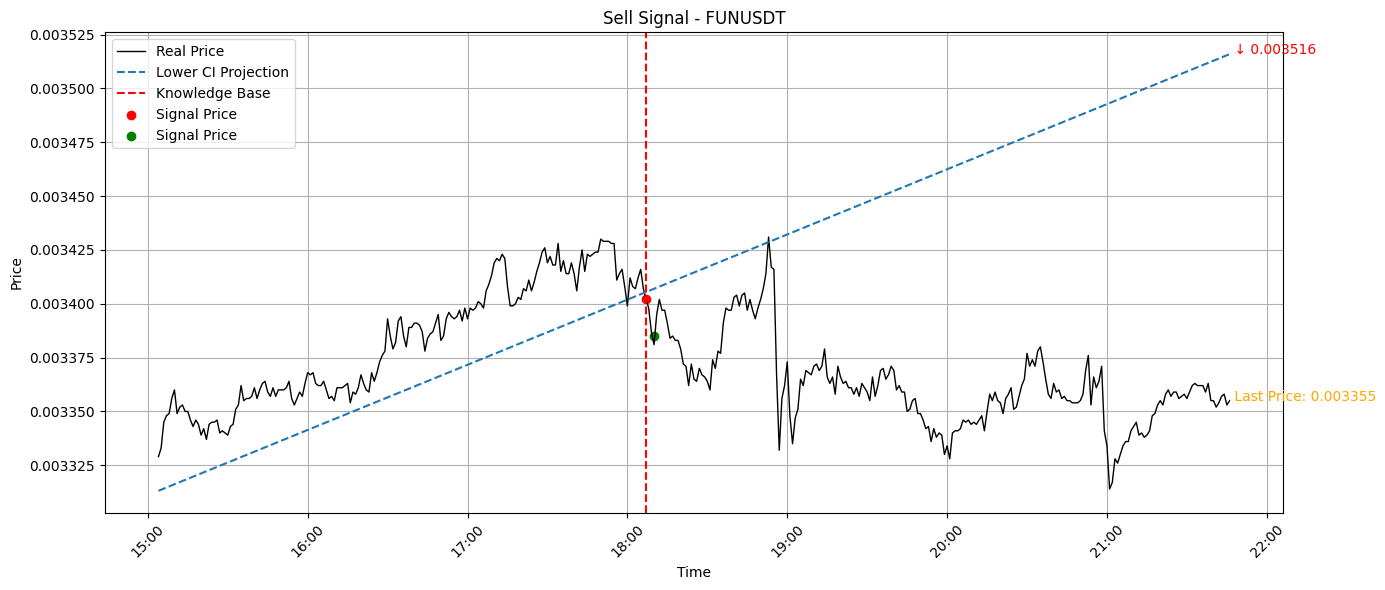

We are at index: 1000
Opening position
We are at index: 2000
sold at 3409.52, took profit at 3392.472400   pnl: 1.0
Slope of lower ci: 0.002617847572272782


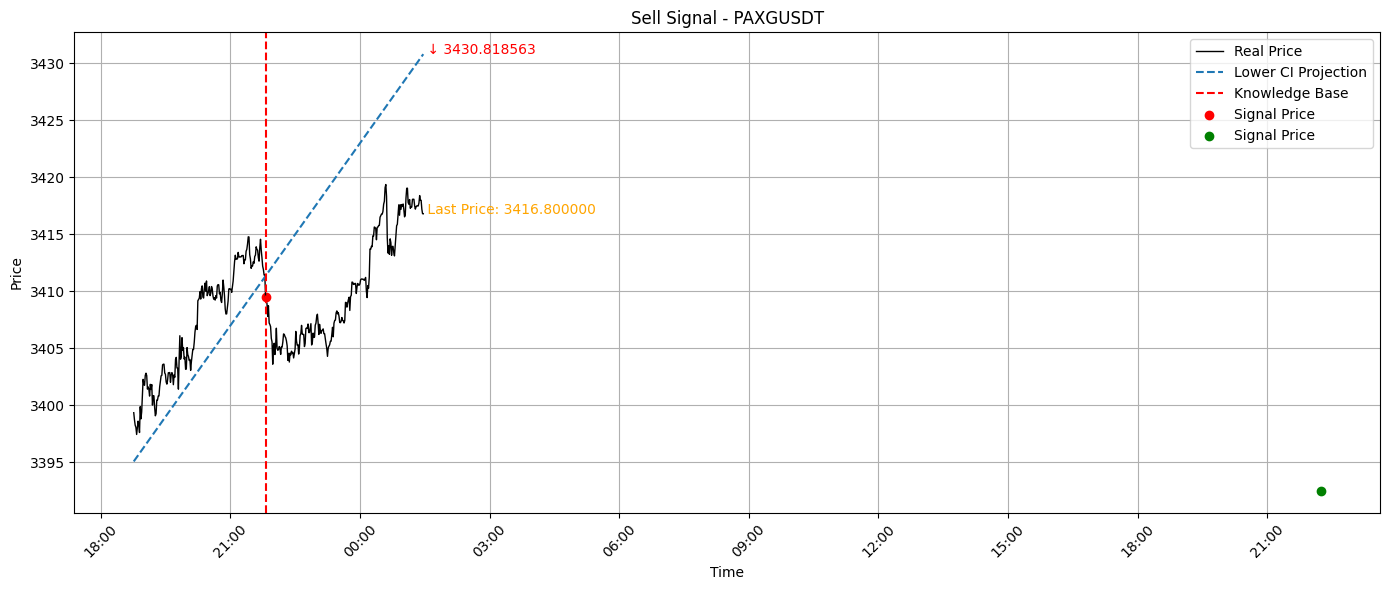

Opening position
sold at 0.22408, stop loss @0.225200   pnl: 0.5
Slope of lower ci: 0.013051423366061802


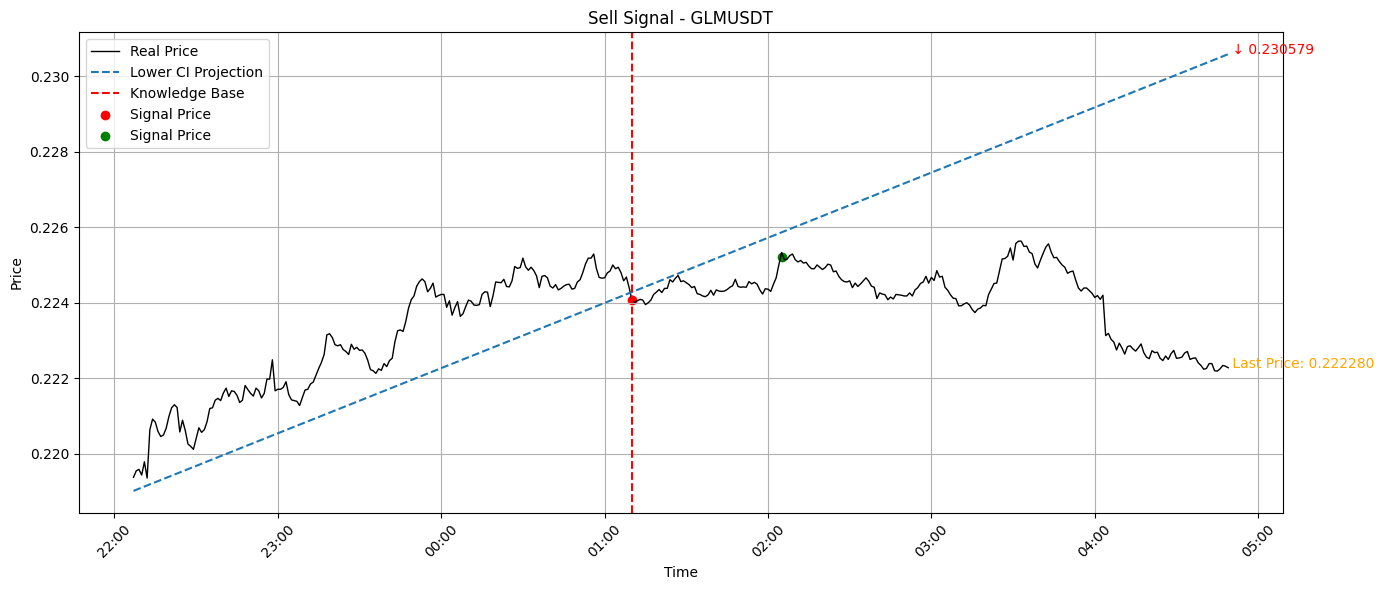

Opening position
sold at 8.226, took profit at 8.184870   pnl: 1.0
Slope of lower ci: 0.01661799895560577


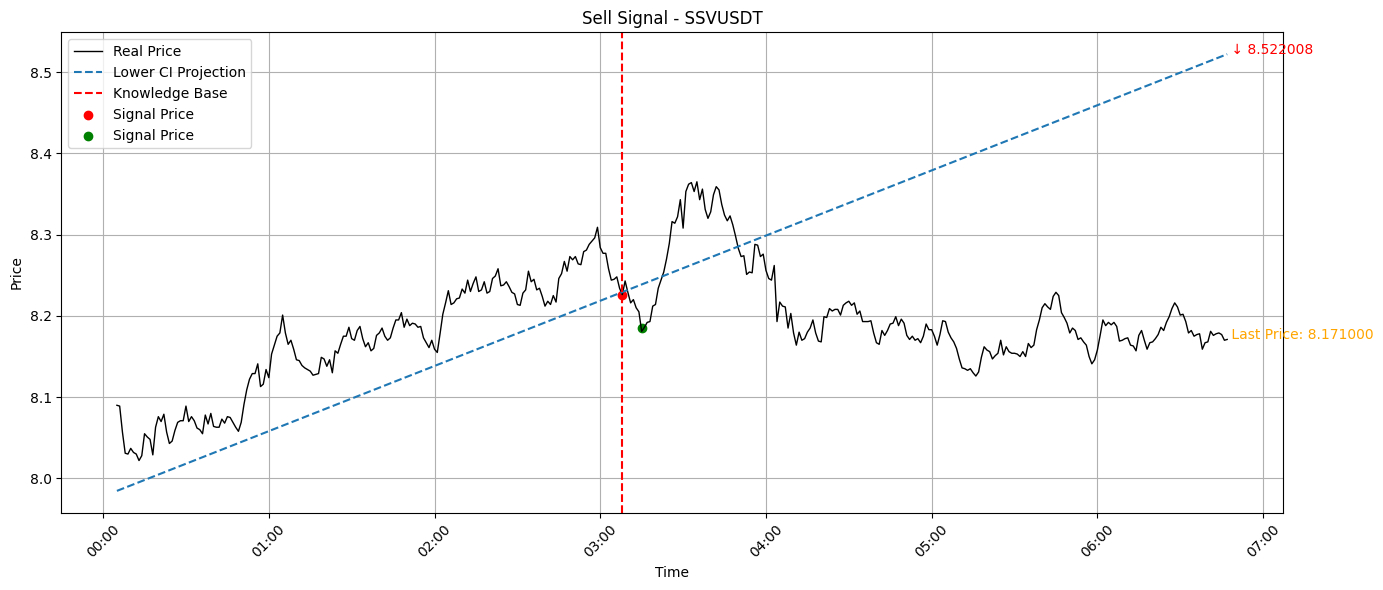

Opening position
sold at 0.1575, stop loss @0.158287   pnl: 0.5
Slope of lower ci: 0.010985177619082277


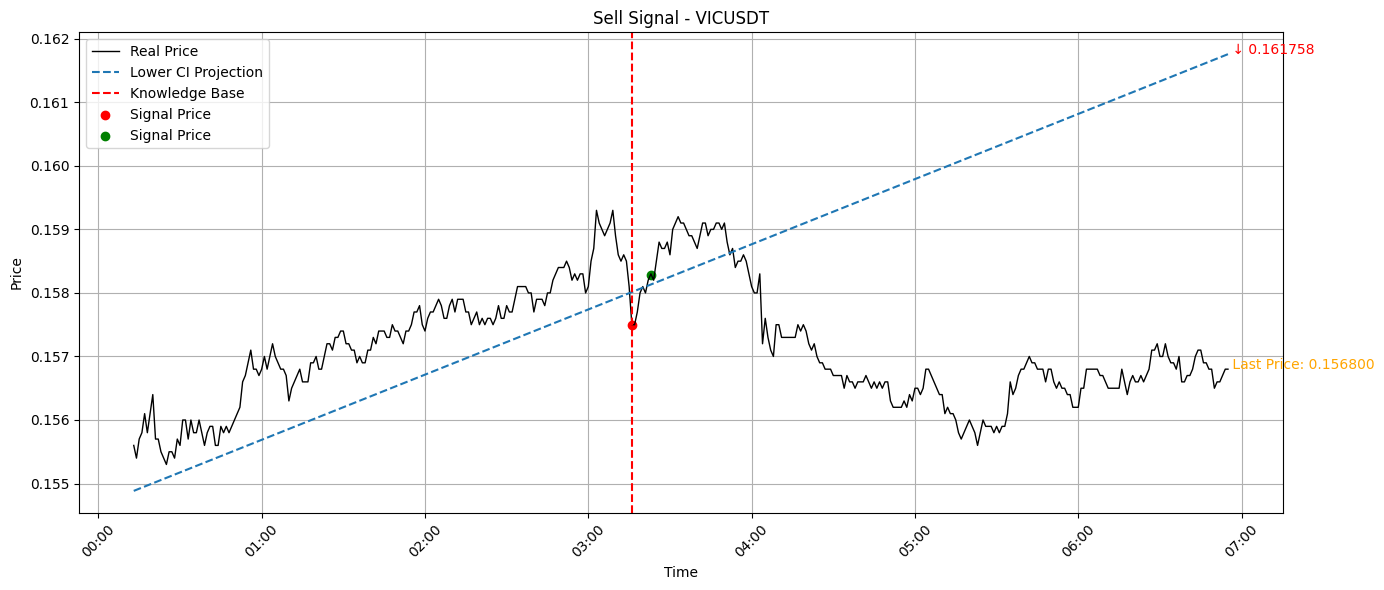

We are at index: 3000
Opening position
sold at 0.02462, took profit at 0.024497   pnl: 1.0
Slope of lower ci: 0.014510016989770754


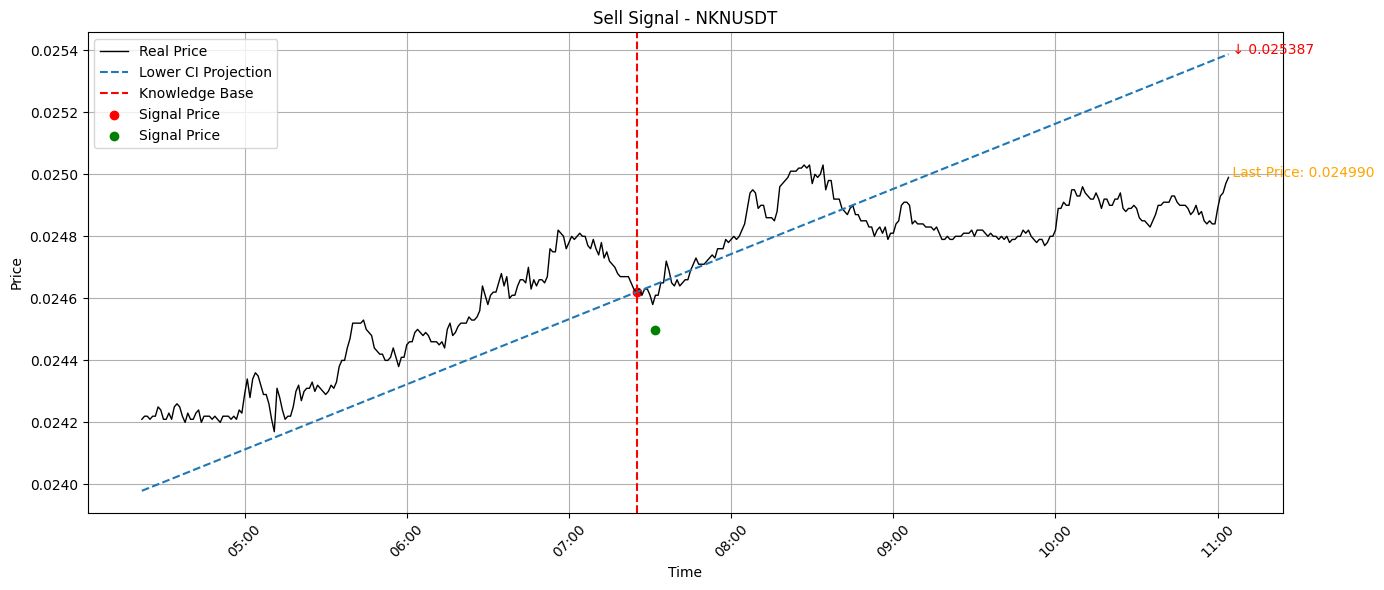

Opening position
sold at 5.549, took profit at 5.521255   pnl: 1.5
Slope of lower ci: 0.01205922313547351


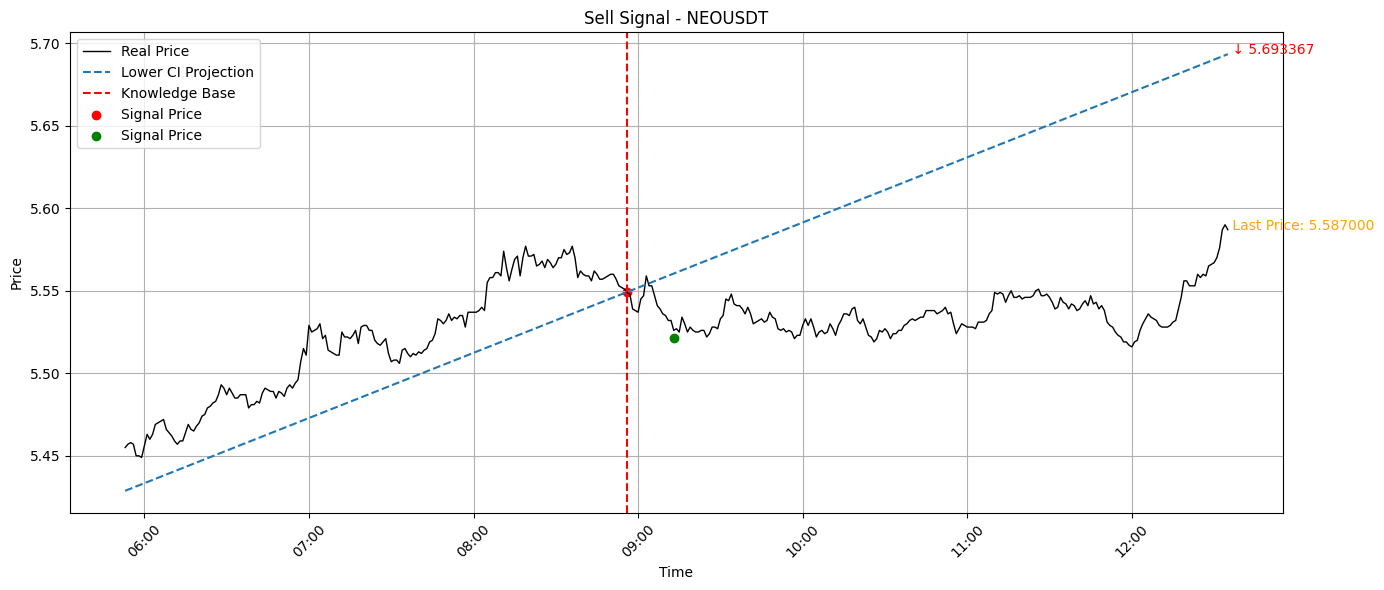

Opening position
sold at 0.12892, took profit at 0.128275   pnl: 2.0
Slope of lower ci: 0.009149190189837357


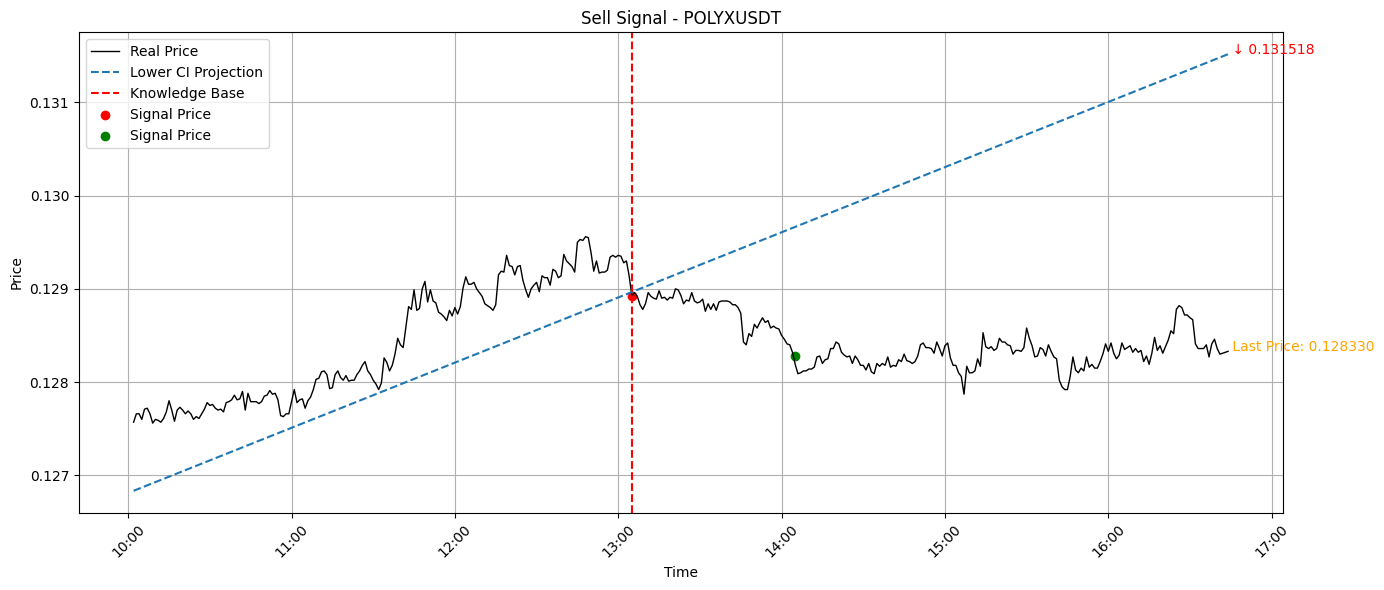

Opening position
sold at 0.07869, took profit at 0.078297   pnl: 2.5
Slope of lower ci: 0.016597175615123215


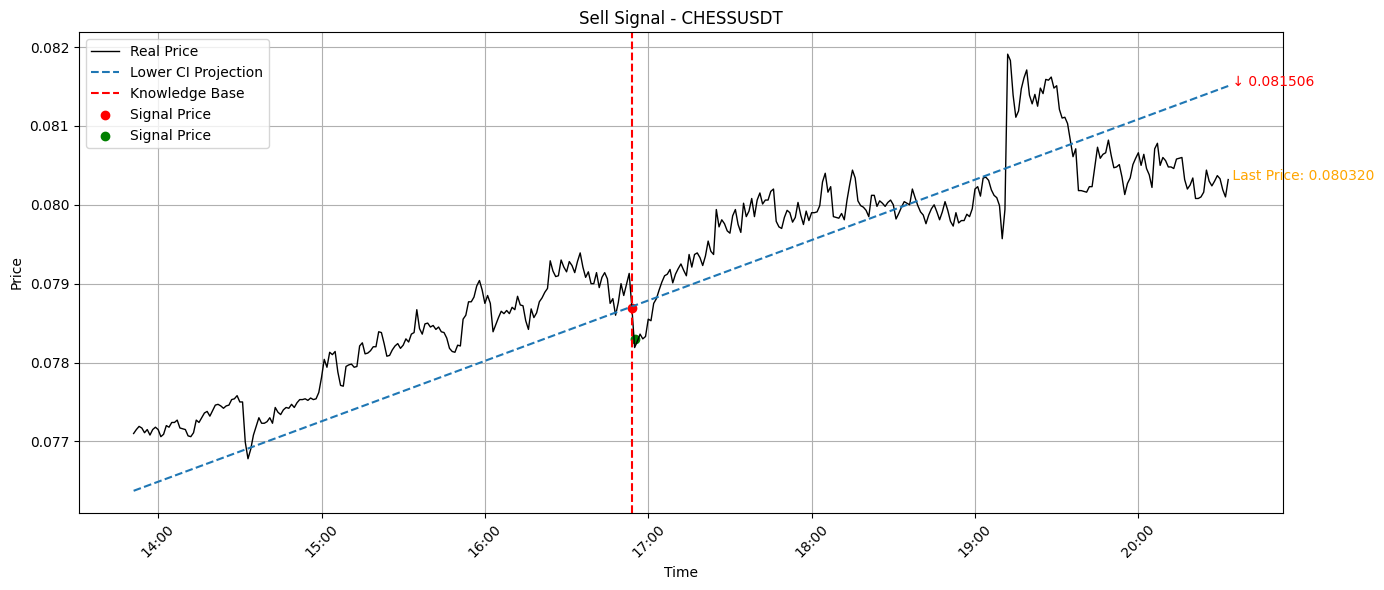

Opening position
We are at index: 4000
sold at 2.1676, took profit at 2.156762   pnl: 3.0
Slope of lower ci: 0.008167076089917449


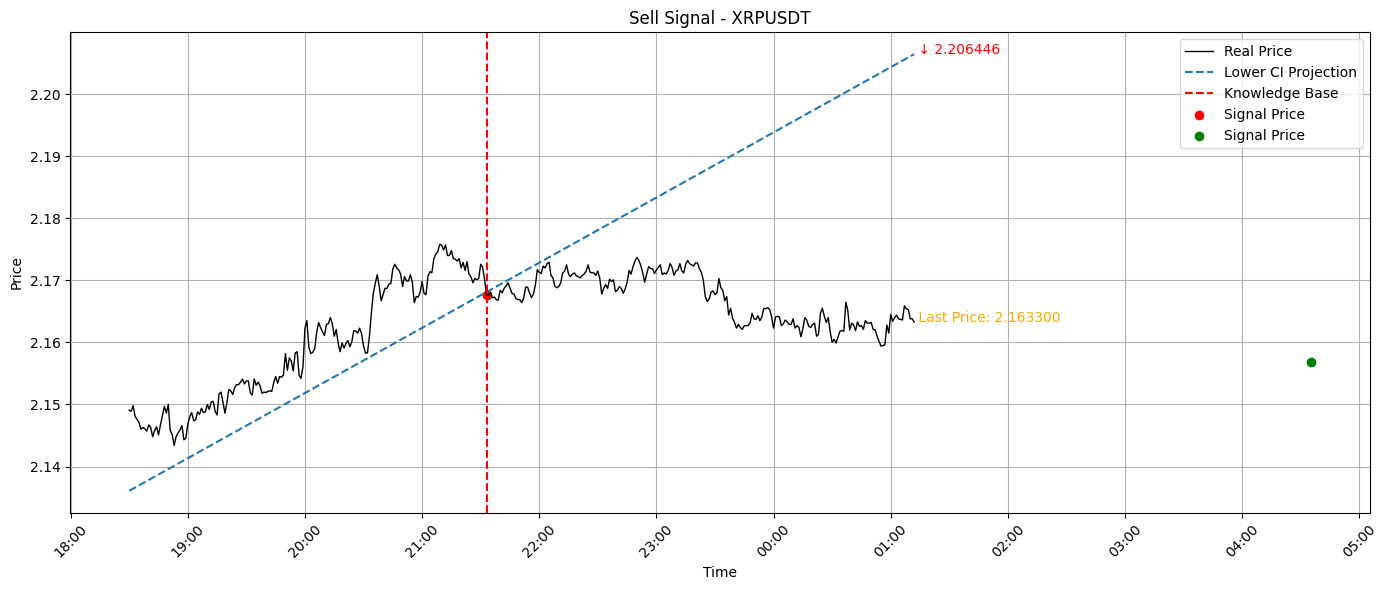

Opening position
sold at 2.4306, stop loss @2.442753   pnl: 2.5
Slope of lower ci: 0.007466390435072939


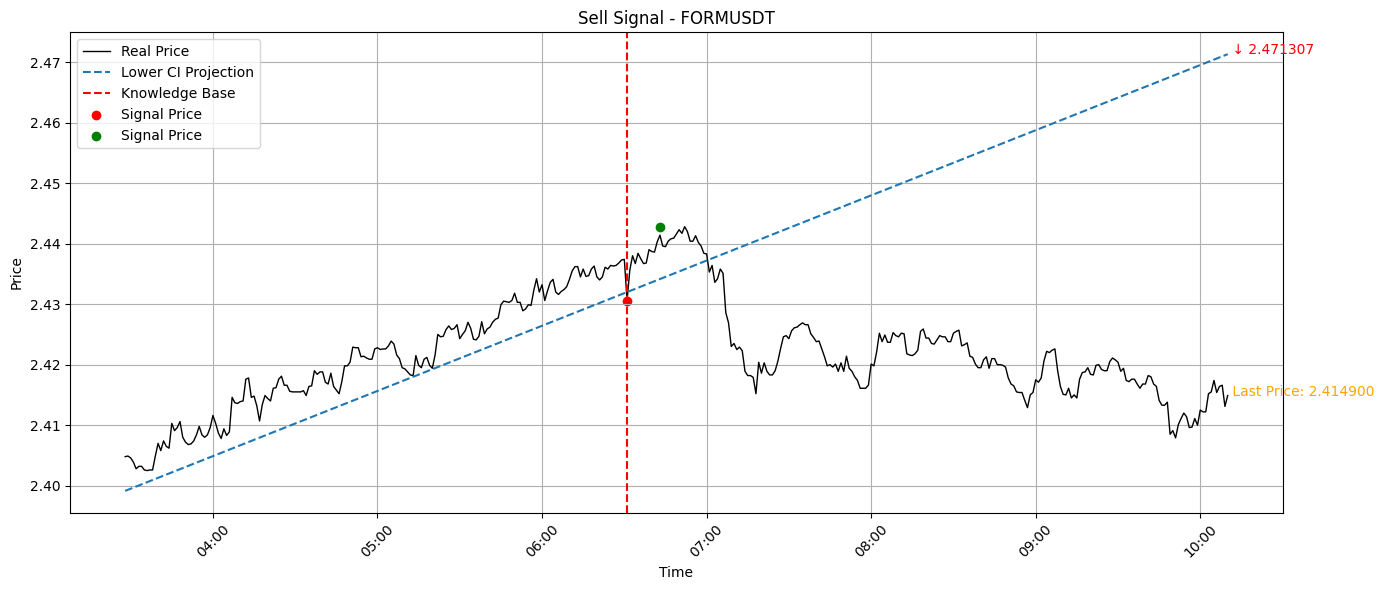

Opening position
sold at 2.4353, took profit at 2.423123   pnl: 3.0
Slope of lower ci: 0.0072017895553528315


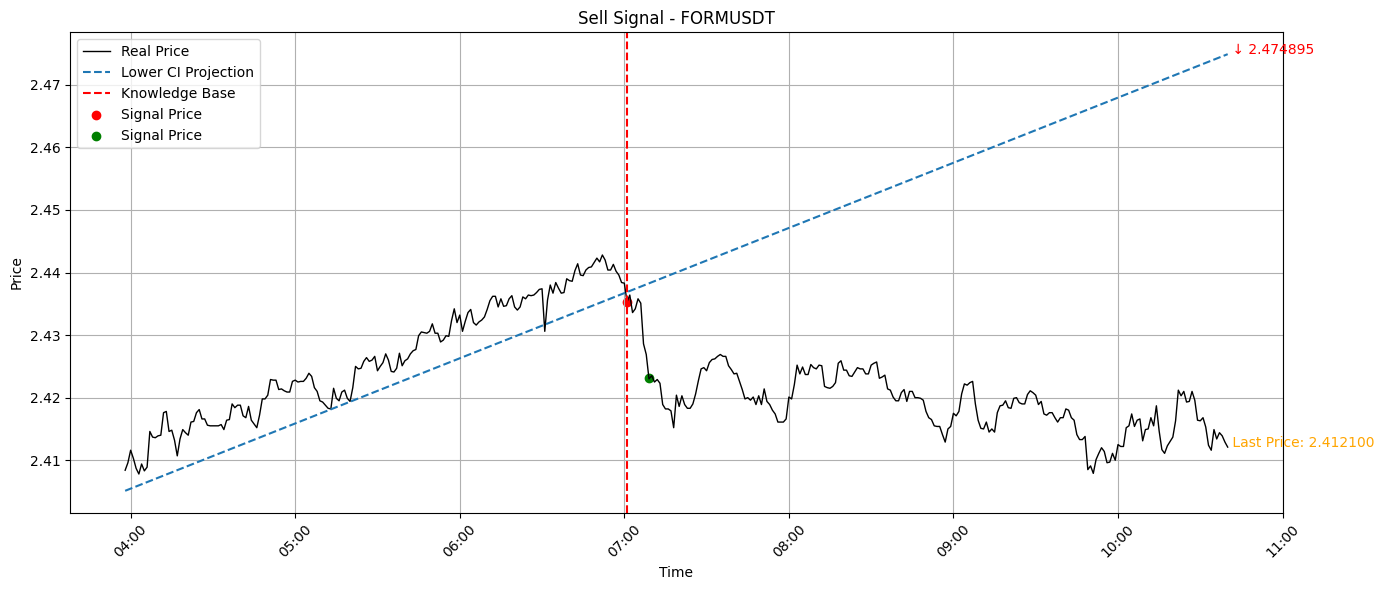

Opening position
sold at 0.2465, took profit at 0.245267   pnl: 3.5
Slope of lower ci: 0.009869669702883745


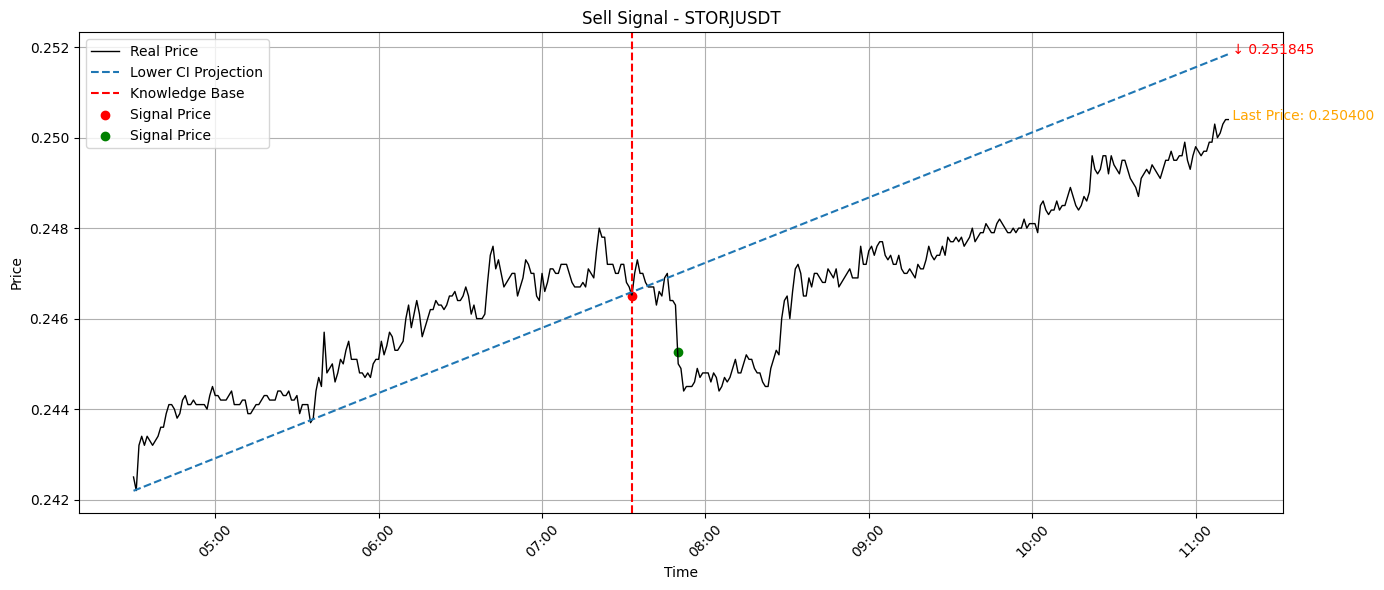

Opening position
sold at 2.611, took profit at 2.597945   pnl: 4.0
Slope of lower ci: 0.016281666228394973


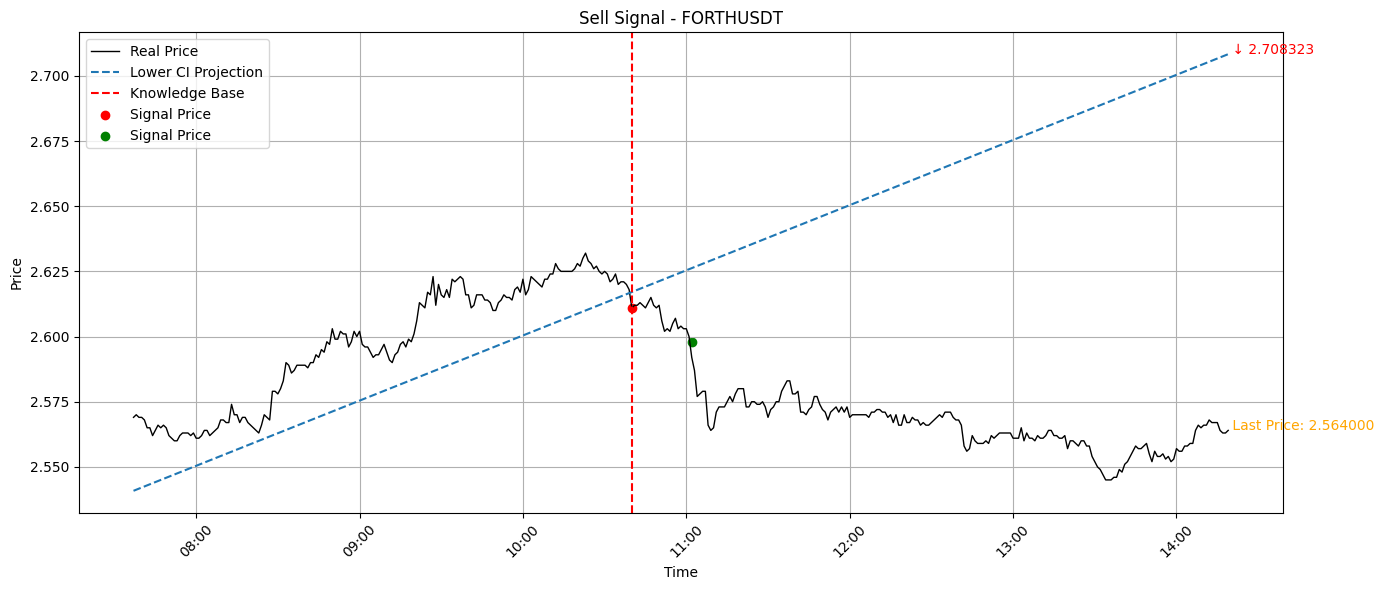

Opening position
sold at 0.03117, stop loss @0.031326   pnl: 3.5
Slope of lower ci: 0.014893334266618076


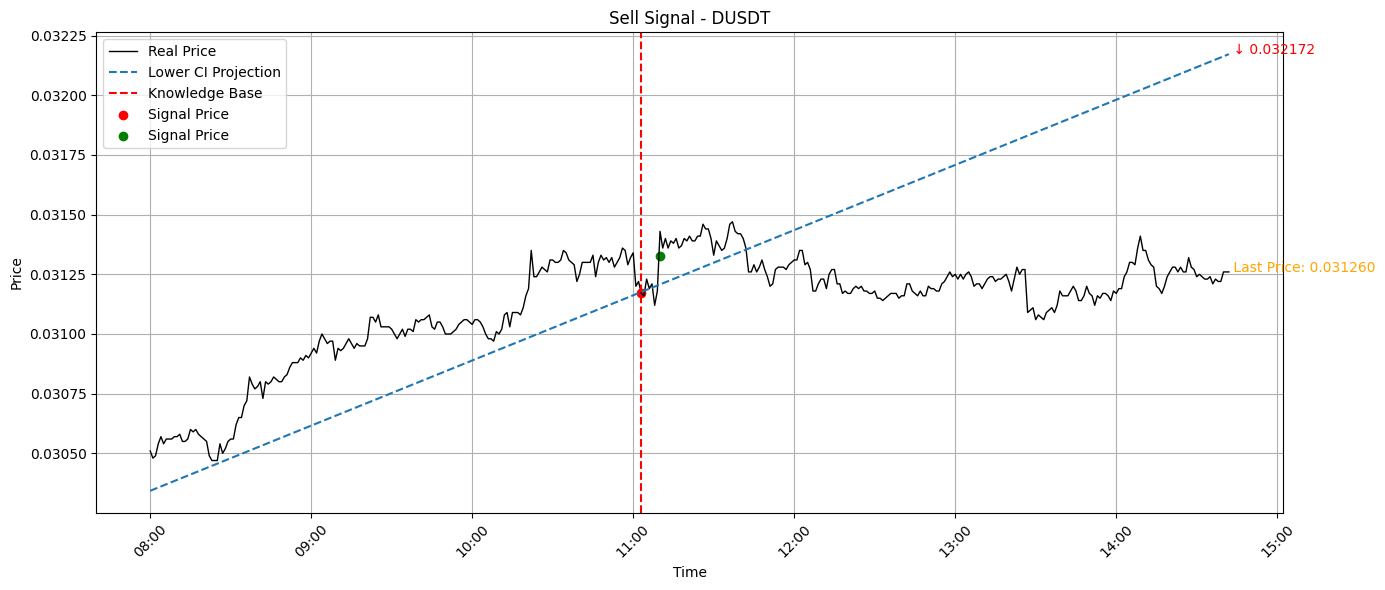

Opening position
sold at 5049.0, took profit at 5023.755000   pnl: 4.0
Slope of lower ci: 0.008363136920080996


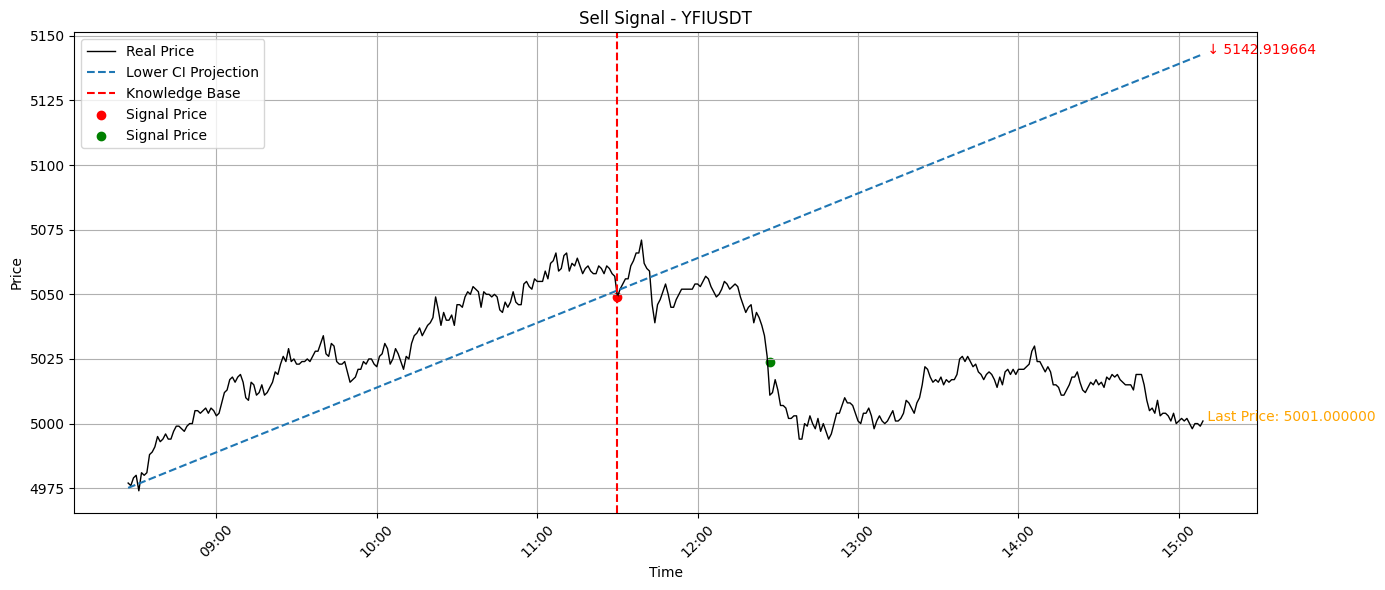

We are at index: 5000
Opening position
sold at 1.4556, stop loss @1.462878   pnl: 3.5
Slope of lower ci: 0.013410085144649753


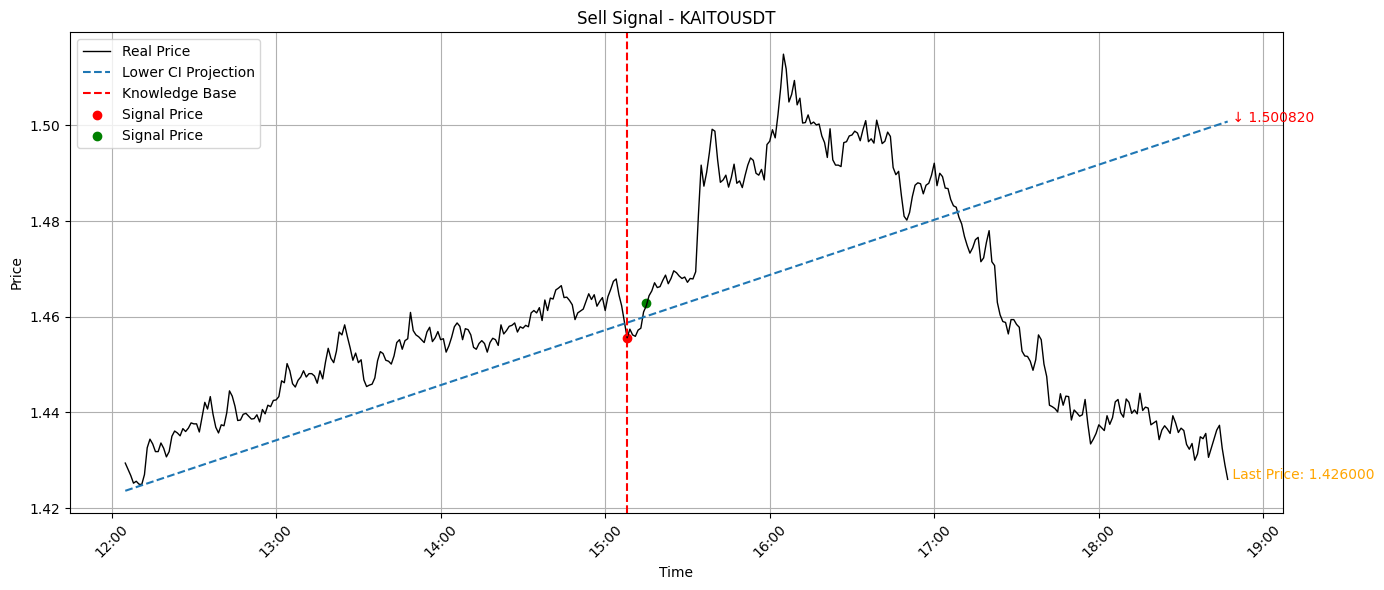

Opening position
sold at 0.07317, stop loss @0.073536   pnl: 3.0
Slope of lower ci: 0.011166003058108387


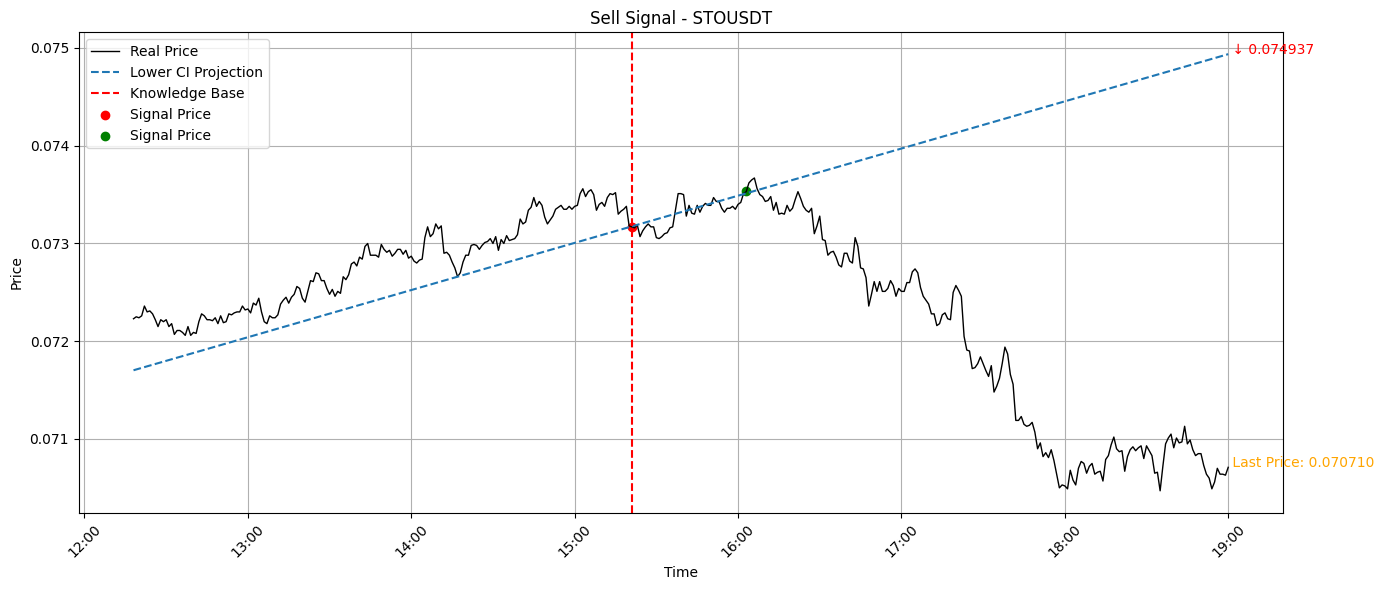

Opening position
sold at 0.3206, took profit at 0.318997   pnl: 3.5
Slope of lower ci: 0.005691108149120306


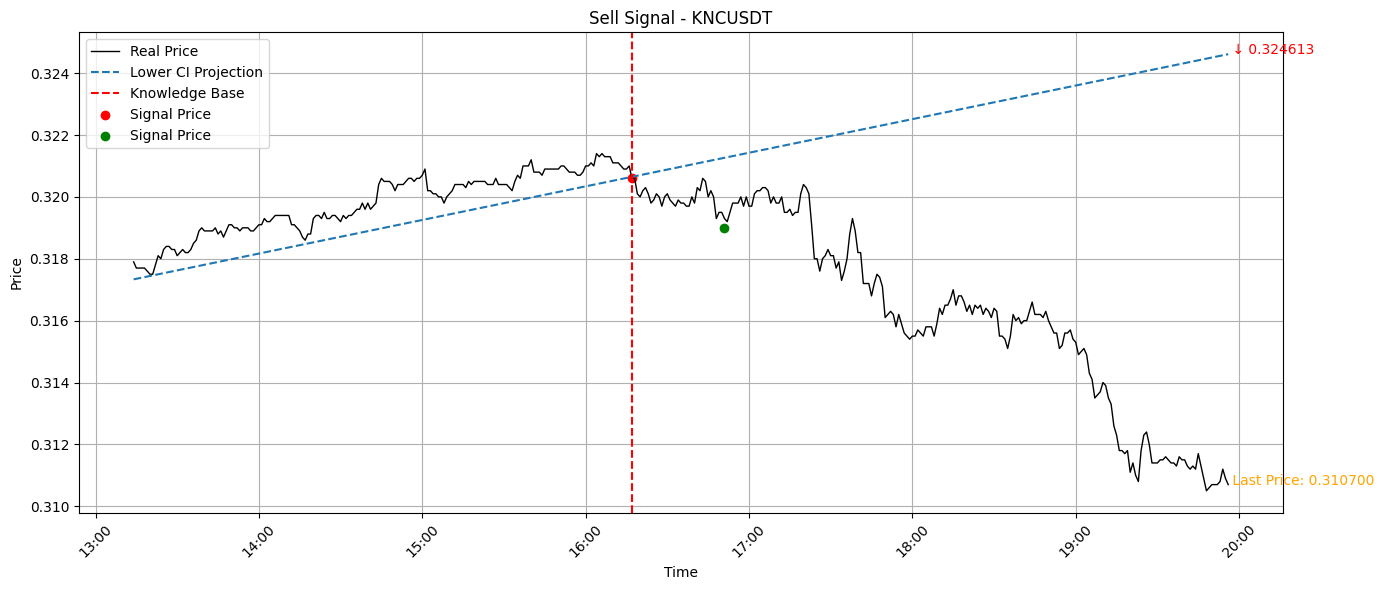

Opening position
sold at 0.19728, took profit at 0.196294   pnl: 4.0
Slope of lower ci: 0.015572609073264375


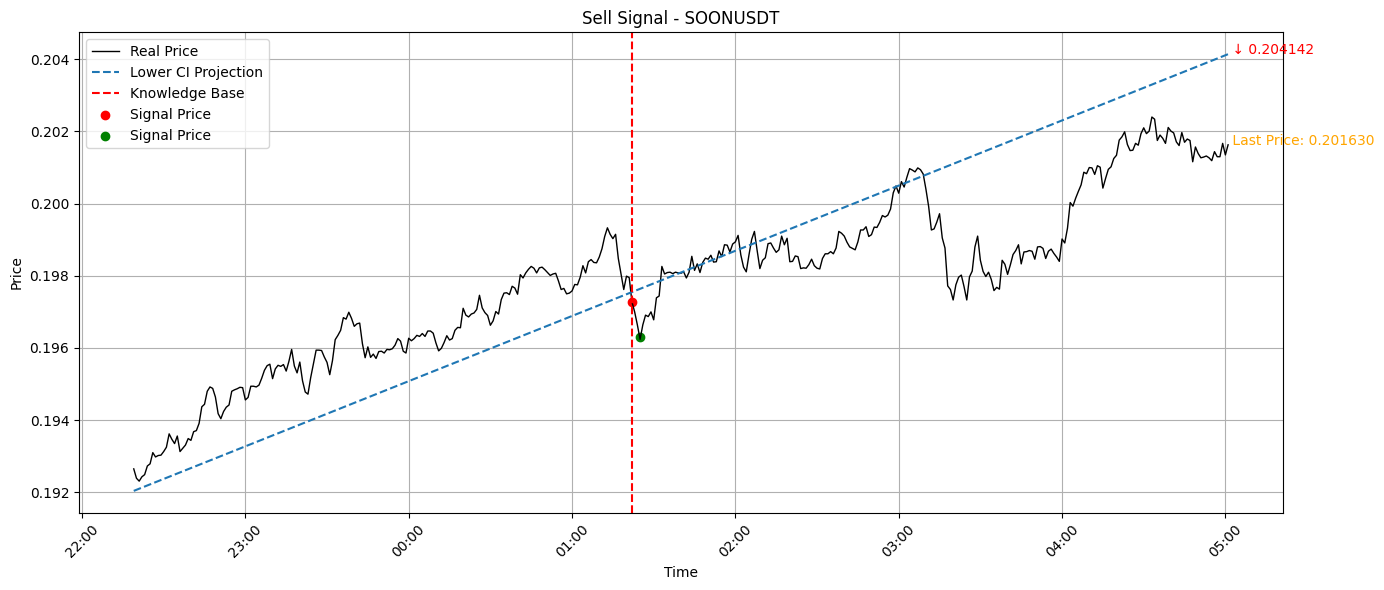

Opening position
sold at 2.281, stop loss @2.292405   pnl: 3.5
Slope of lower ci: 0.010667462380884578


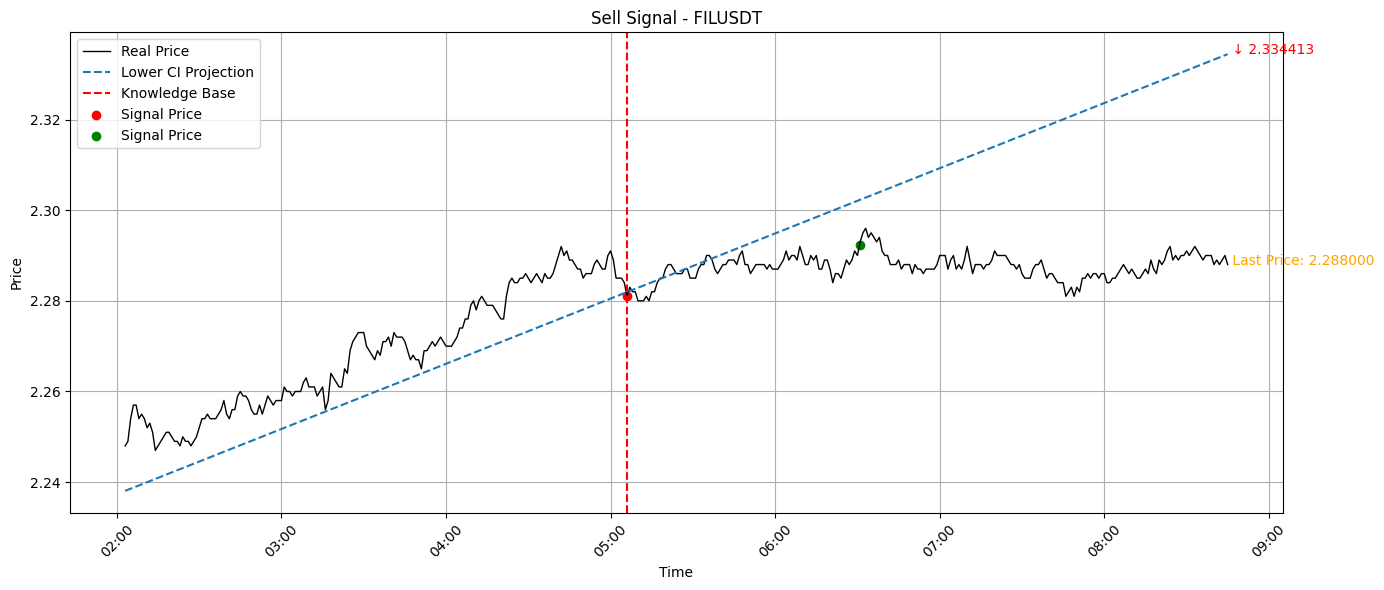

Opening position
sold at 6.022, took profit at 5.991890   pnl: 4.0
Slope of lower ci: 0.016781600597671396


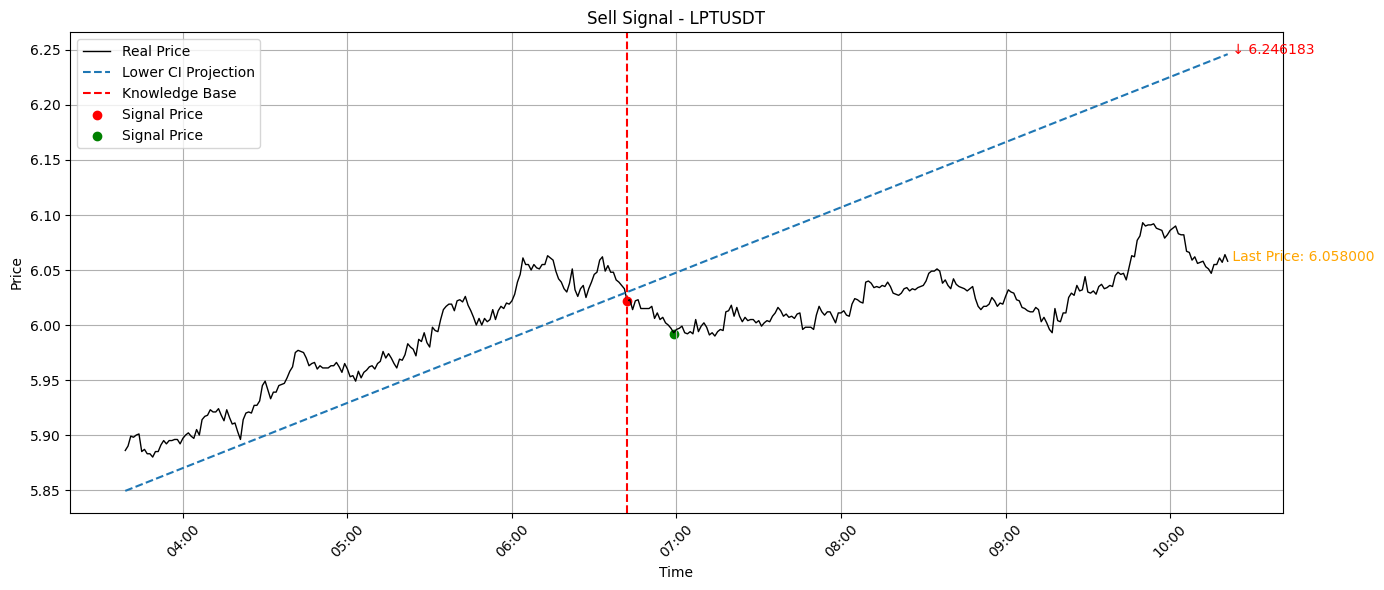

Opening position
We are at index: 6000
sold at 0.12294, took profit at 0.122325   pnl: 4.5
Slope of lower ci: 0.006774638250447472


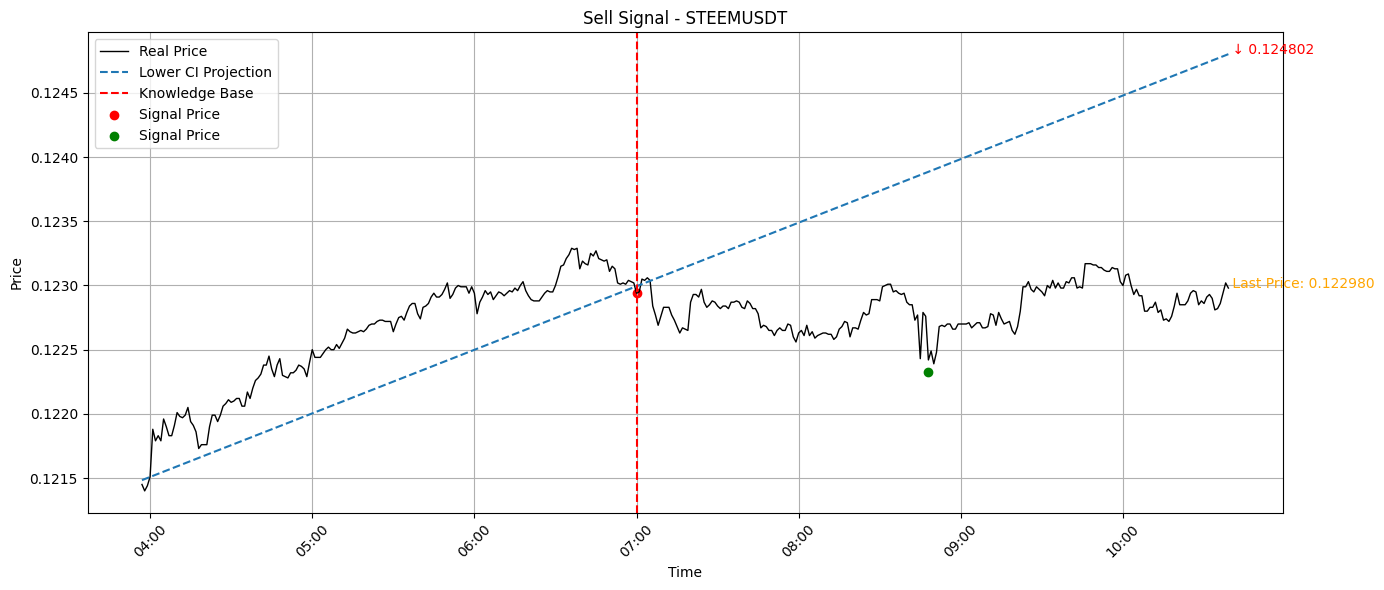

Opening position
sold at 0.03616, stop loss @0.036341   pnl: 4.0
Slope of lower ci: 0.011246662151261843


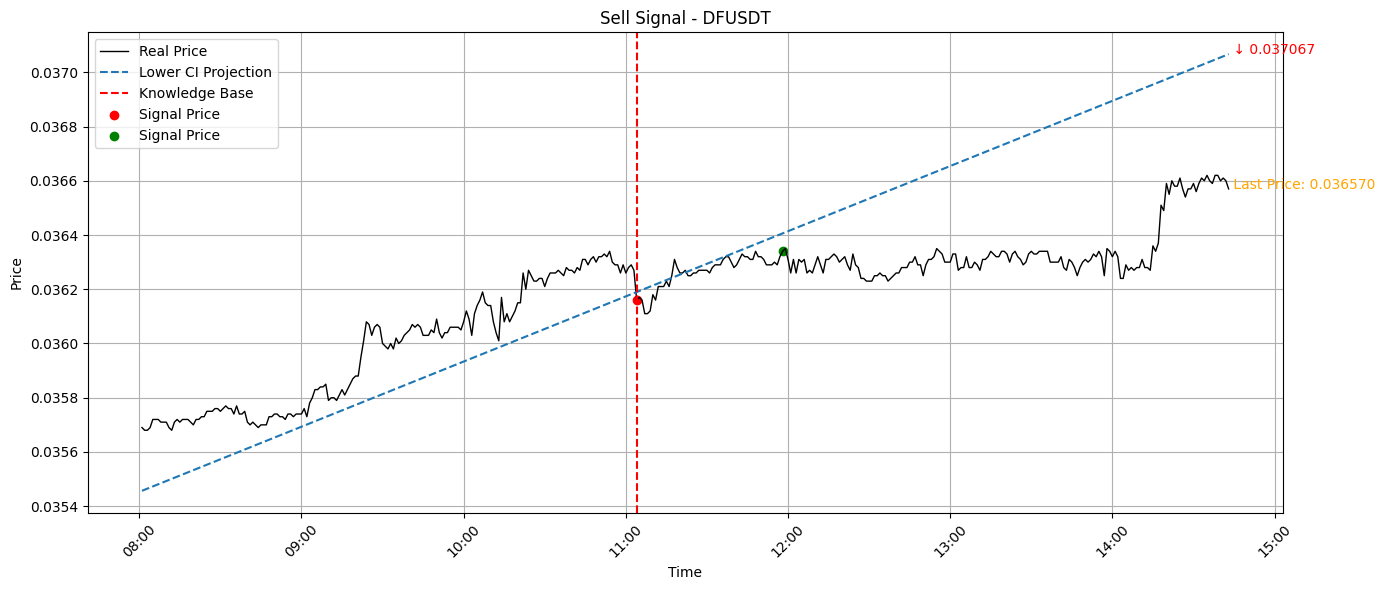

Opening position
sold at 0.3017, stop loss @0.303208   pnl: 3.5
Slope of lower ci: 0.012322120285713358


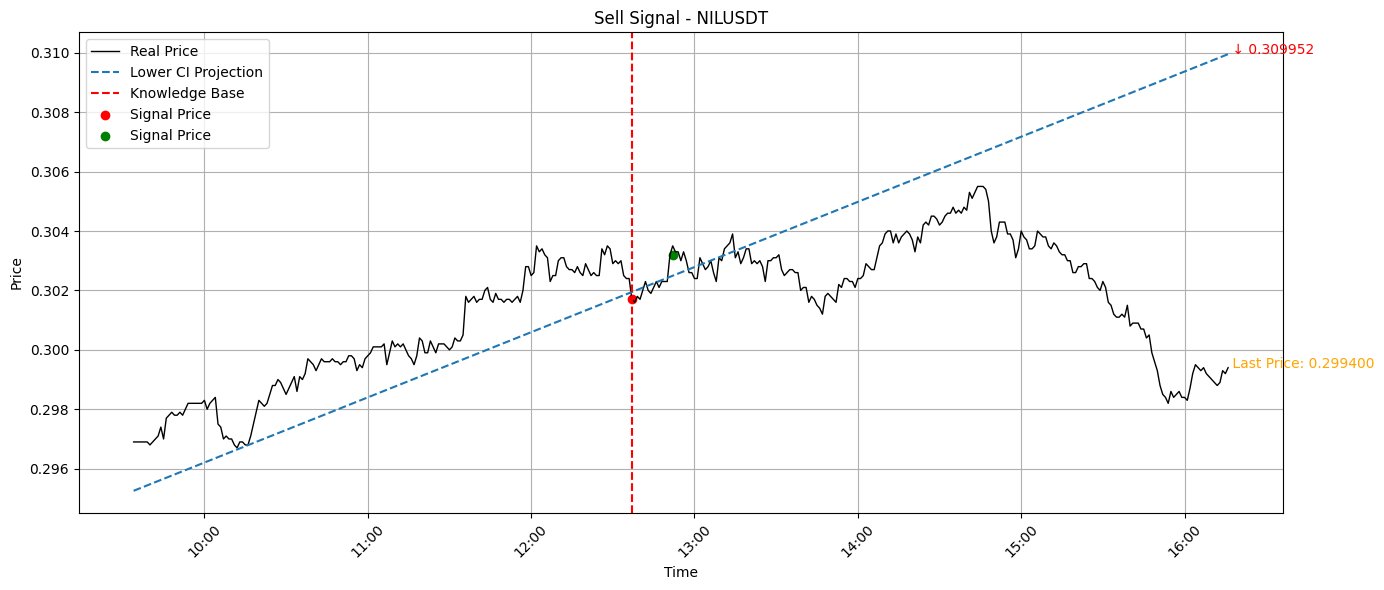

Opening position
sold at 0.1109, took profit at 0.110345   pnl: 4.0
Slope of lower ci: 0.010645406284585704


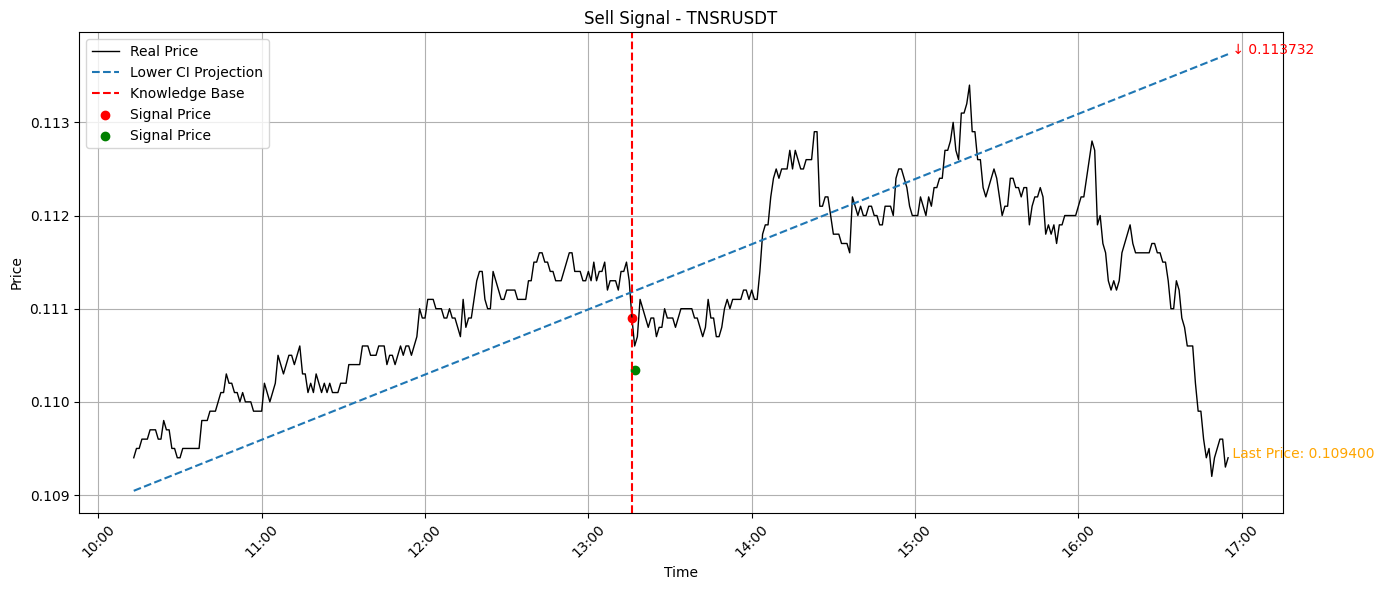

Opening position
sold at 103829.6, took profit at 103310.452000   pnl: 4.5
Slope of lower ci: 0.0031687426746899233


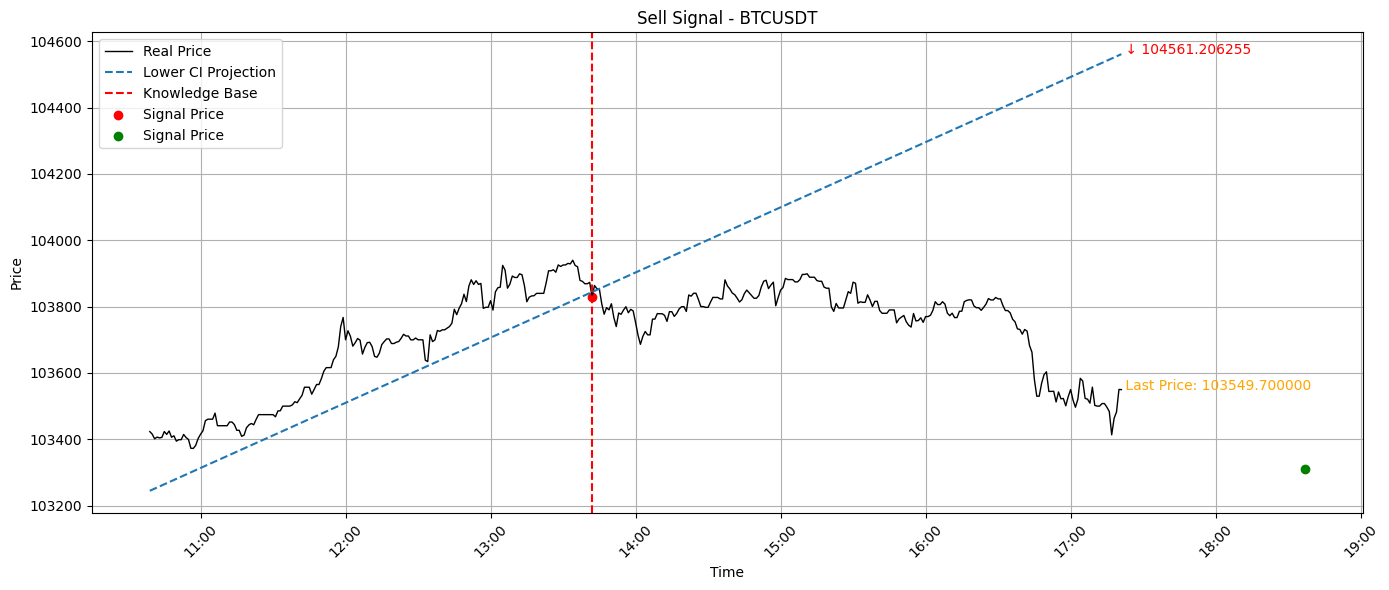

Opening position
We are at index: 7000
We are at index: 8000


In [11]:
if __name__ == '__main__':
    global pnl
    data = prepare_data()
    cooldown = 10 
    last_signal = { sym: None for sym in data.keys() }
    N = 8641
    position = False
    
    for i in range(N-1-WIDE_SIZE):

        if i%1000 == 0:
            print(f'We are at index: {i}')

        if not position:
            for sym, df_full in data.items():
       
                last = last_signal[sym]
                if last is not None and i < last + cooldown:
                    continue

                window = df_full.iloc[i : i+WINDOW_SIZE] #0-182, 1-183

                if window['close'].nunique() <= 1:
                    continue

                model = create_model(window)
                if model.rsquared <= 0.90:
                    continue
                

                preds = get_predictions(window, model, alpha=0.01)            

                #print(get_next_low(preds['obs_ci_lower'],i+WINDOW_SIZE)) # gives 183
                if get_slope(window,preds)>0.017 or get_slope(window,preds)<0:
                    continue

                signal_found = False

                cur_low_proj = get_next_low(preds['obs_ci_lower'],182) # df last element
                next_low_proj = get_next_low(preds['obs_ci_lower']) #new bars assumption
                cur_p    = window['close'].iloc[-1]
                next_p    = df_full['close'].iloc[i+WINDOW_SIZE]

                #sell condition
                if cur_p > cur_low_proj and next_p < next_low_proj:
                        sell_bar     = i + WINDOW_SIZE # we buy at next bars close
                        sell_time    = df_full['open_time'].iloc[sell_bar]
                        sell_price   = df_full['close'].iloc[sell_bar]
                        position = True
                        test_window = df_full.iloc[i:i+WIDE_SIZE]
                        lower_proj = get_lower_series(preds['obs_ci_lower'],WIDE_SIZE)
                        df = df_full.copy()
                        print('Opening position')
                if position == True:
                    break
        
        elif position:
            window = df.iloc[i : i+WINDOW_SIZE] #0-182, 1-183
            next_low  = df['low'].iloc[i+WINDOW_SIZE]
            next_high = df['high'].iloc[i+WINDOW_SIZE]

            if next_low < sell_price * 0.995:
                buy_bar   = i + WINDOW_SIZE
                buy_time  = df['open_time'].iloc[buy_bar]
                buy_price = sell_price * 0.995
                pnl += 0.5
                print(f'sold at {sell_price}, took profit at {buy_price:.6f}   pnl: {round(pnl,1)}')
                print('Slope of lower ci:',get_slope(window,preds))
                tp_slope.append(get_slope(window,preds))
                position = False
                draw(test_window, lower_proj, sym,sell_time, sell_price,buy_time, buy_price)

            elif next_high > sell_price * 1.005:
                buy_bar   = i + WINDOW_SIZE
                buy_time  = df['open_time'].iloc[buy_bar]
                buy_price = sell_price * 1.005
                pnl -= 0.5
                print(f'sold at {sell_price}, stop loss @{buy_price:.6f}   pnl: {round(pnl,1)}')
                print('Slope of lower ci:',get_slope(window,preds))
                stop_slope.append(get_slope(window,preds))
                position = False
                draw(test_window, lower_proj, sym,sell_time, sell_price,buy_time, buy_price)